In [2]:
from ml_pipeline.dataset import load_excel
DATA_PATH = 'elevator_failure_prediction.xlsx'

# this creates a dict of excel sheets
xl_dict = load_excel(DATA_PATH)
xl_dict.keys()

dict_keys(['data'])

In [3]:
import pandas as pd

# Assuming `xl_dict['data']` is your DataFrame
raw = xl_dict['data']

# Drop the 'Time' column
features = raw.drop(columns=['Time'])

# Display the updated DataFrame
print(features.head())


   Temperature  Humidity   RPM  Vibrations  Pressure   Sensor1     Sensor2  \
0     31.11716   74.1715  72.0       16.81        76  0.791225  203.793426   
1     31.11716   74.1715  72.0       16.81        76  0.791225  203.793426   
2     32.08894   74.0803  72.0       17.08        76  0.803988  204.411886   
3     31.67221   73.9272  72.0       15.79        76  0.743260  204.363994   
4     31.95202   73.7603  72.0       16.84        76  0.792391  203.947834   

    Sensor3     Sensor4   Sensor5    Sensor6  Status  
0  0.582975  799.101683  7.149643  15.842287       0  
1  0.582975  799.101683  7.149643  15.842287       0  
2  0.575500  834.897700  7.089729  15.739743       0  
3  0.575500  805.467950  7.135375  15.731202       0  
4  0.584042  822.142650  7.092582  15.773928       0  


In [4]:
raw.Status.value_counts().sort_index()


Status
0    40584
1        2
2     4054
Name: count, dtype: int64

In [5]:
status_values = raw['Status'].unique()
print(f"Distinct values in 'Status': {status_values}")


Distinct values in 'Status': [0 1 2]


In [6]:
# Replace value 2 with 1 in the 'Status' column
features['Status'] = features['Status'].replace(2, 1)

# Verify the changes
print(features['Status'].unique())


[0 1]


In [7]:
from sklearn.model_selection import train_test_split

# Split data into features and target
X = features.drop(
    columns=['Status', 'Sensor1', 'Temperature', 'Pressure',  'Vibrations', 'Sensor2', 'Sensor6','Sensor5', 'RPM'],
    errors='ignore'
)

y = features['Status']
print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Index(['Humidity', 'Sensor3', 'Sensor4'], dtype='object')


In [94]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the models with fixed hyperparameters
models = {
    'lr': LogisticRegression(penalty='l2', C=0.75, random_state=0),
    'rf': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
}

# Evaluation metrics
scoring_funcs = [metrics.roc_auc_score, metrics.average_precision_score]

# K-Fold Stratified splitting
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Initialize evaluation results
eval_results = []
fold_num = 0

# Perform Stratified K-Fold Cross-Validation
for train_folds, test_folds in skf.split(X_train, y_train):
    # Train-test split for this fold
    X_train_fold, X_test_fold = X_train.iloc[train_folds], X_train.iloc[test_folds]
    print(X_train_fold.columns)
    y_train_fold, y_test_fold = y_train.iloc[train_folds], y_train.iloc[test_folds]

    # Pre-processing: Standard scaling
    scaler = StandardScaler()
    scaler.fit(X_train_fold)

    X_train_fold_scaled = scaler.transform(X_train_fold)
    X_test_fold_scaled = scaler.transform(X_test_fold)

    # Train and evaluate models
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_fold_scaled, y_train_fold)

        # Evaluate the model
        y_pred_on_test_fold = model.predict_proba(X_test_fold_scaled)[:, 1]

        # Collect evaluation metrics
        fold_results = [fold_num, model_name]
        for scoring_metric in scoring_funcs:
            fold_results.append(scoring_metric(y_test_fold, y_pred_on_test_fold))
        
        eval_results.append(fold_results)
    fold_num += 1

# Print evaluation results for each fold
print("Evaluation Results per Fold:")
print("Fold\tModel\tROC-AUC\tPR-AUC")
for fold in eval_results:
    print(f"{fold[0]}\t{fold[1]}\t{fold[2]:.2f}\t{fold[3]:.2f}")

# Compute mean and standard deviation of metrics
roc_auc_scores = [result[2] for result in eval_results]
pr_auc_scores = [result[3] for result in eval_results]

print("\nMean ROC-AUC: {:.2f} ± {:.2f}".format(np.mean(roc_auc_scores), np.std(roc_auc_scores)))
print("Mean PR-AUC: {:.2f} ± {:.2f}".format(np.mean(pr_auc_scores), np.std(pr_auc_scores)))

# Final Training and Evaluation on the Test Set
# Retrain the best model based on ROC-AUC (or PR-AUC)
best_model = models['lr']  # Suppose logistic regression gave the best result

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

best_model.fit(X_train_scaled, y_train)

y_pred_on_test = best_model.predict_proba(X_test_scaled)[:, 1]
test_roc = metrics.roc_auc_score(y_test, y_pred_on_test)
test_pr = metrics.average_precision_score(y_test, y_pred_on_test)

print("\nFinal Test ROC-AUC: {:.2f}".format(test_roc))
print("Final Test PR-AUC: {:.2f}".format(test_pr))


Index(['Humidity', 'Sensor3', 'Sensor4'], dtype='object')
Index(['Humidity', 'Sensor3', 'Sensor4'], dtype='object')
Index(['Humidity', 'Sensor3', 'Sensor4'], dtype='object')
Index(['Humidity', 'Sensor3', 'Sensor4'], dtype='object')
Index(['Humidity', 'Sensor3', 'Sensor4'], dtype='object')
Index(['Humidity', 'Sensor3', 'Sensor4'], dtype='object')
Index(['Humidity', 'Sensor3', 'Sensor4'], dtype='object')
Index(['Humidity', 'Sensor3', 'Sensor4'], dtype='object')
Index(['Humidity', 'Sensor3', 'Sensor4'], dtype='object')
Index(['Humidity', 'Sensor3', 'Sensor4'], dtype='object')
Evaluation Results per Fold:
Fold	Model	ROC-AUC	PR-AUC
0	lr	0.96	0.82
0	rf	0.98	0.87
1	lr	0.97	0.86
1	rf	0.98	0.88
2	lr	0.96	0.86
2	rf	0.98	0.86
3	lr	0.96	0.83
3	rf	0.98	0.87
4	lr	0.95	0.83
4	rf	0.98	0.89
5	lr	0.97	0.84
5	rf	0.99	0.89
6	lr	0.97	0.84
6	rf	0.98	0.89
7	lr	0.96	0.86
7	rf	0.99	0.89
8	lr	0.97	0.88
8	rf	0.99	0.92
9	lr	0.97	0.84
9	rf	0.99	0.92

Mean ROC-AUC: 0.97 ± 0.01
Mean PR-AUC: 0.87 ± 0.03

Final Test R

In [1]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Define the models with fixed hyperparameters
models = {
    'lr1': LogisticRegression(penalty=None),
    'lr2': LogisticRegression(penalty='l2', C=0.75),
    'lr3': LogisticRegression(penalty='l2', C=0.5),
    
    'dt1': DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=2, random_state=0),
    'dt2': DecisionTreeClassifier(max_features='log2', min_samples_leaf=2, random_state=0),
    
    '3nn': KNeighborsClassifier(n_neighbors=3),
    '5nn': KNeighborsClassifier(n_neighbors=5),
    
    'rf1': RandomForestClassifier(n_estimators=100, random_state=0),
    'rf2': RandomForestClassifier(n_estimators=1000, random_state=0)
}

# Evaluation metrics
scoring_funcs = [metrics.roc_auc_score, metrics.average_precision_score]

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# K-Fold Stratified splitting for model selection on the training set
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Initialize evaluation results
eval_results = []
fold_num = 0

# Perform Stratified K-Fold Cross-Validation
for train_folds, test_folds in skf.split(X_train, y_train):
    # Train-test split for this fold
    X_train_fold, X_test_fold = X_train.iloc[train_folds], X_train.iloc[test_folds]
    y_train_fold, y_test_fold = y_train.iloc[train_folds], y_train.iloc[test_folds]

    # Pre-processing: Standard scaling
    scaler = StandardScaler()
    scaler.fit(X_train_fold)

    X_train_fold_scaled = scaler.transform(X_train_fold)
    X_test_fold_scaled = scaler.transform(X_test_fold)

    # Train and evaluate models
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_fold_scaled, y_train_fold)

        # Evaluate the model
        y_pred_on_test_fold = model.predict_proba(X_test_fold_scaled)[:, 1]

        # Collect evaluation metrics
        fold_results = [fold_num, model_name]
        for scoring_metric in scoring_funcs:
            fold_results.append(scoring_metric(y_test_fold, y_pred_on_test_fold))
        
        eval_results.append(fold_results)
    fold_num += 1

# Print evaluation results for each fold
print("Evaluation Results per Fold:")
print("Fold\tModel\tROC-AUC\tPR-AUC")
for fold in eval_results:
    print(f"{fold[0]}\t{fold[1]}\t{fold[2]:.2f}\t{fold[3]:.2f}")

# Compute mean and standard deviation of metrics
roc_auc_scores = [result[2] for result in eval_results]
pr_auc_scores = [result[3] for result in eval_results]

print("\nMean ROC-AUC: {:.2f} ± {:.2f}".format(np.mean(roc_auc_scores), np.std(roc_auc_scores)))
print("Mean PR-AUC: {:.2f} ± {:.2f}".format(np.mean(pr_auc_scores), np.std(pr_auc_scores)))

# Select the best model based on mean PR-AUC
model_scores = {model_name: [] for model_name in models.keys()}

for result in eval_results:
    model_name = result[1]
    pr_auc = result[3]  # Assuming PR-AUC is at index 3
    model_scores[model_name].append(pr_auc)

# Determine the best model based on mean PR-AUC
best_model_name = max(model_scores, key=lambda name: np.mean(model_scores[name]))
print(f"Best model selected based on PR-AUC: {best_model_name}")

# Retrieve the best model
best_model = models[best_model_name]

# Pre-process: Standard scaling on the full training set
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Retrain the best model on the entire training set
best_model.fit(X_train_scaled, y_train)

# Evaluate the retrained best model on the validation set (held-out set)
y_pred_on_val = best_model.predict_proba(X_val_scaled)[:, 1]
val_roc = metrics.roc_auc_score(y_val, y_pred_on_val)
val_pr = metrics.average_precision_score(y_val, y_pred_on_val)

# Print final validation set results
print("\nValidation Set ROC-AUC: {:.2f}".format(val_roc))
print("Validation Set PR-AUC: {:.2f}".format(val_pr))

# Final Training and Evaluation on the Test Set
# Pre-process: Standard scaling on the full training + validation set
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

scaler.fit(X_full_train)

X_full_train_scaled = scaler.transform(X_full_train)
X_test_scaled = scaler.transform(X_test)

# Retrain the best model on the entire (train + validation) set
best_model.fit(X_full_train_scaled, y_full_train)

# Evaluate the retrained best model on the test set
y_pred_on_test = best_model.predict_proba(X_test_scaled)[:, 1]
test_roc = metrics.roc_auc_score(y_test, y_pred_on_test)
test_pr = metrics.average_precision_score(y_test, y_pred_on_test)

# Print final test set results
print("\nFinal Test ROC-AUC: {:.2f}".format(test_roc))
print("Final Test PR-AUC: {:.2f}".format(test_pr))


NameError: name 'X' is not defined

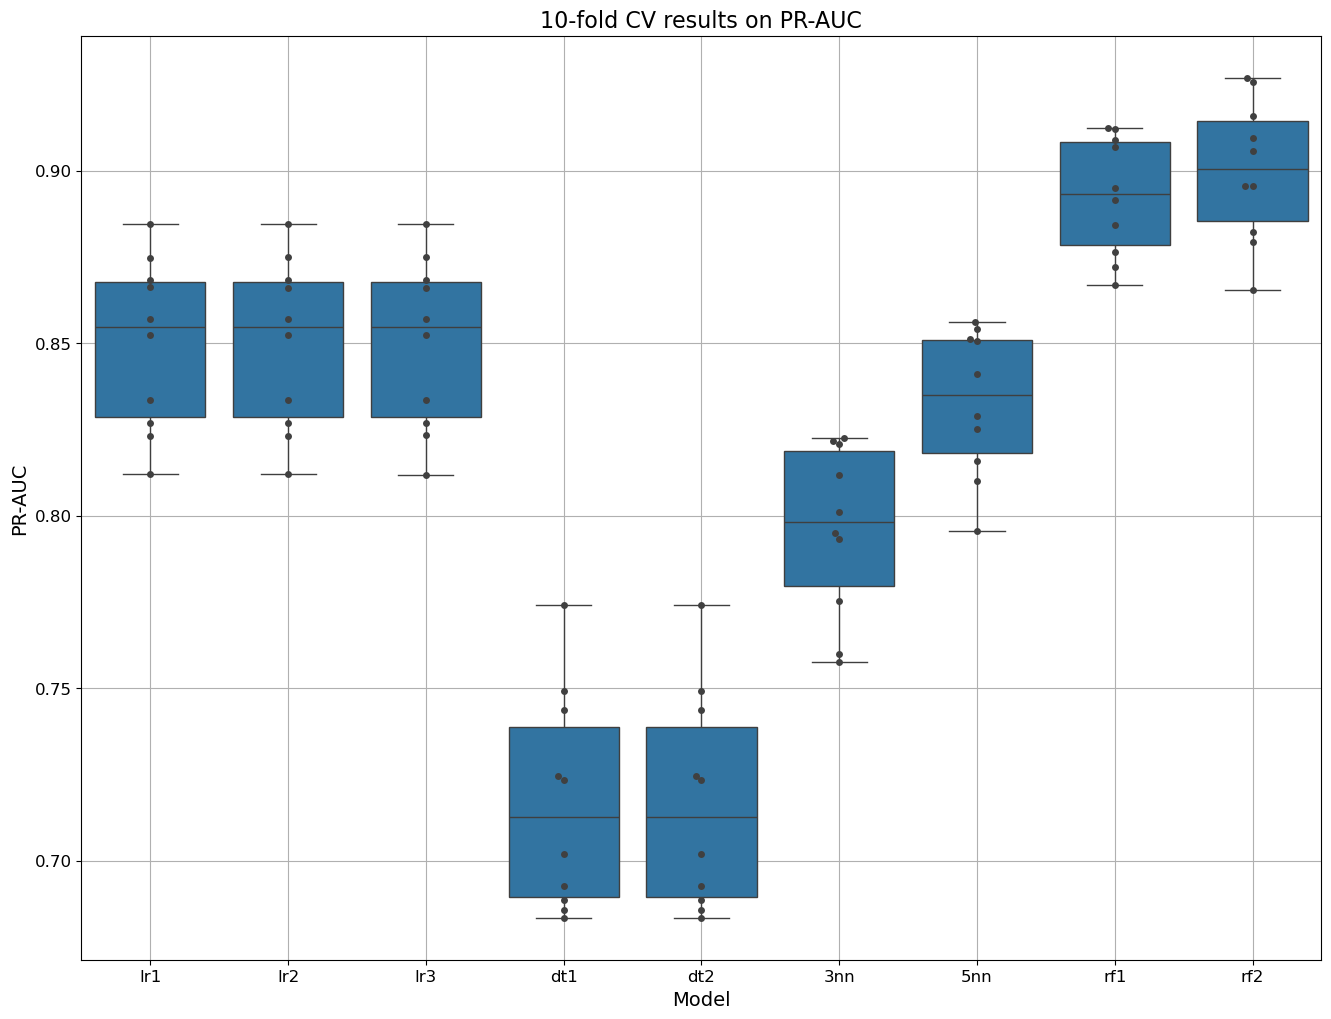

In [97]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Plot PR-AUC results
plt.figure(figsize=(16, 12))
ax = sns.boxplot(x="Model", y="PR-AUC", data=eval_df)
ax = sns.swarmplot(x="Model", y="PR-AUC", data=eval_df, color=".25")
plt.title('10-fold CV results on PR-AUC', fontsize=16)
plt.ylabel('PR-AUC', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()


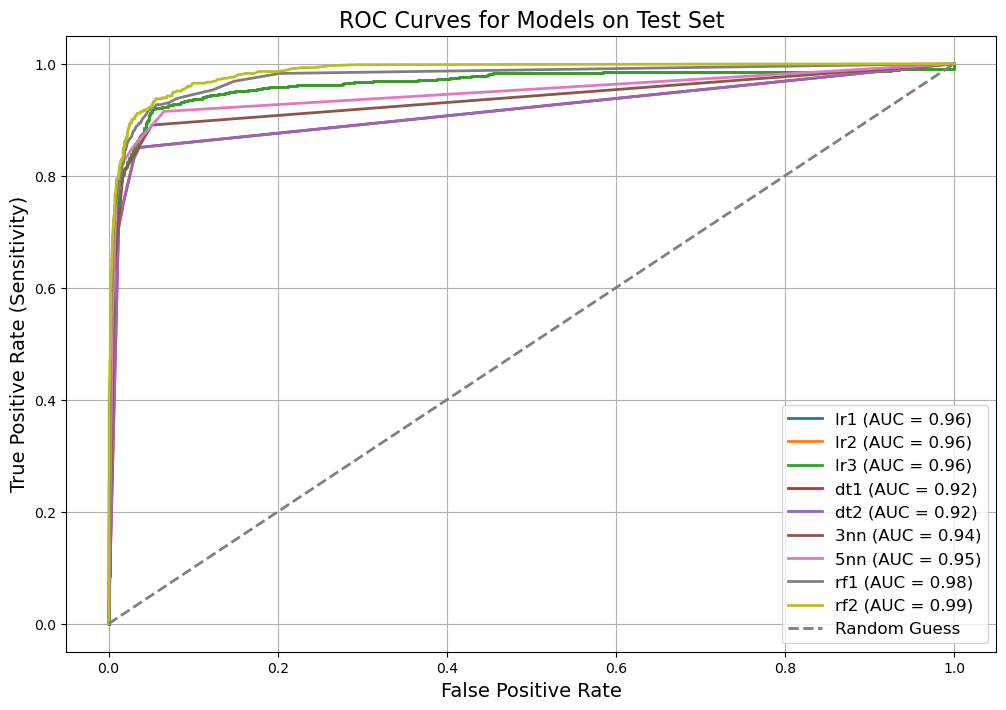

In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC curves for all models on the test set
plt.figure(figsize=(12, 8))

for model_name, model in models.items():
    # Scale the test set
    X_test_scaled = scaler.transform(X_test)
    
    # Predict probabilities on the test set
    y_pred_probs = model.predict_proba(X_test_scaled)[:, 1]
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot each model's ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Random guess line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')

# Add labels, title, and legend
plt.title('ROC Curves for Models on Test Set', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()


In [8]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import pandas as pd

# Define the models with fixed hyperparameters
models = {
    'lr1': LogisticRegression(penalty=None),
    'lr2': LogisticRegression(penalty='l2', C=0.75),
    'lr3': LogisticRegression(penalty='l2', C=0.5),
    
    'dt1': DecisionTreeClassifier(max_features='sqrt', min_samples_leaf=2, random_state=0),
    'dt2': DecisionTreeClassifier(max_features='log2', min_samples_leaf=2, random_state=0),
    
    '3nn': KNeighborsClassifier(n_neighbors=3),
    '5nn': KNeighborsClassifier(n_neighbors=5),
    
    'rf1': RandomForestClassifier(n_estimators=100, random_state=0),
    'rf2': RandomForestClassifier(n_estimators=1000, random_state=0)
}

# Evaluation metrics
scoring_funcs = [metrics.roc_auc_score, metrics.average_precision_score]

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# K-Fold Stratified splitting for model selection on the training set
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# Initialize evaluation results
eval_results = []
fold_num = 0

# Perform Stratified K-Fold Cross-Validation
for train_folds, test_folds in skf.split(X_train, y_train):
    # Train-test split for this fold
    X_train_fold, X_test_fold = X_train.iloc[train_folds], X_train.iloc[test_folds]
    y_train_fold, y_test_fold = y_train.iloc[train_folds], y_train.iloc[test_folds]

    # Pre-processing: Standard scaling
    scaler = StandardScaler()
    scaler.fit(X_train_fold)

    X_train_fold_scaled = scaler.transform(X_train_fold)
    X_test_fold_scaled = scaler.transform(X_test_fold)

    # Train and evaluate models
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_fold_scaled, y_train_fold)

        # Evaluate the model
        y_pred_on_test_fold = model.predict_proba(X_test_fold_scaled)[:, 1]

        # Collect evaluation metrics
        fold_results = [fold_num, model_name]
        for scoring_metric in scoring_funcs:
            fold_results.append(scoring_metric(y_test_fold, y_pred_on_test_fold))
        
        eval_results.append(fold_results)
    fold_num += 1

# Convert eval_results to a DataFrame for better manipulation
columns = ["Fold", "Model", "ROC-AUC", "PR-AUC"]
eval_df = pd.DataFrame(eval_results, columns=columns)

# Sort by PR-AUC in descending order
top_results = eval_df.sort_values(by="PR-AUC", ascending=False).head(10)

# Display the top 10 PR-AUC results
print("\nTop 10 Models Based on PR-AUC:")
print(top_results.to_string(index=False))

# Compute mean and standard deviation of metrics
roc_auc_scores = [result[2] for result in eval_results]
pr_auc_scores = [result[3] for result in eval_results]

print("\nMean ROC-AUC: {:.2f} ± {:.2f}".format(np.mean(roc_auc_scores), np.std(roc_auc_scores)))
print("Mean PR-AUC: {:.2f} ± {:.2f}".format(np.mean(pr_auc_scores), np.std(pr_auc_scores)))

# Select the best model based on mean PR-AUC
model_scores = {model_name: [] for model_name in models.keys()}

for result in eval_results:
    model_name = result[1]
    pr_auc = result[3]  # Assuming PR-AUC is at index 3
    model_scores[model_name].append(pr_auc)

# Determine the best model based on mean PR-AUC
best_model_name = max(model_scores, key=lambda name: np.mean(model_scores[name]))
print(f"\nBest model selected based on PR-AUC: {best_model_name}")

# Retrieve the best model
best_model = models[best_model_name]

# Pre-process: Standard scaling on the full training set
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Retrain the best model on the entire training set
best_model.fit(X_train_scaled, y_train)

# Evaluate the retrained best model on the validation set (held-out set)
y_pred_on_val = best_model.predict_proba(X_val_scaled)[:, 1]
val_roc = metrics.roc_auc_score(y_val, y_pred_on_val)
val_pr = metrics.average_precision_score(y_val, y_pred_on_val)

# Print final validation set results
print("\nValidation Set ROC-AUC: {:.2f}".format(val_roc))
print("Validation Set PR-AUC: {:.2f}".format(val_pr))

# Final Training and Evaluation on the Test Set
# Pre-process: Standard scaling on the full training + validation set
X_full_train = pd.concat([X_train, X_val])
y_full_train = pd.concat([y_train, y_val])

scaler.fit(X_full_train)

X_full_train_scaled = scaler.transform(X_full_train)
X_test_scaled = scaler.transform(X_test)

# Retrain the best model on the entire (train + validation) set
best_model.fit(X_full_train_scaled, y_full_train)

# Evaluate the retrained best model on the test set
y_pred_on_test = best_model.predict_proba(X_test_scaled)[:, 1]
test_roc = metrics.roc_auc_score(y_test, y_pred_on_test)
test_pr = metrics.average_precision_score(y_test, y_pred_on_test)

# Print final test set results
print("\nFinal Test ROC-AUC: {:.2f}".format(test_roc))
print("Final Test PR-AUC: {:.2f}".format(test_pr))



Top 10 Models Based on PR-AUC:
 Fold Model  ROC-AUC   PR-AUC
    9   rf2 0.985861 0.926944
    0   rf2 0.988759 0.925678
    3   rf2 0.988799 0.915918
    9   rf1 0.984194 0.912433
    0   rf1 0.983568 0.912065
    2   rf2 0.984961 0.909387
    3   rf1 0.987861 0.908745
    2   rf1 0.981828 0.906718
    8   rf2 0.985599 0.905571
    6   rf2 0.982587 0.895595

Mean ROC-AUC: 0.95 ± 0.03
Mean PR-AUC: 0.82 ± 0.07

Best model selected based on PR-AUC: rf2

Validation Set ROC-AUC: 0.98
Validation Set PR-AUC: 0.91

Final Test ROC-AUC: 0.99
Final Test PR-AUC: 0.90
